### **Installs & Imports**

In [1]:
!pip install transformers datasets scikit-learn

In [2]:
import re
import os
import json
import torch
import random
import numpy as np
import pandas as pd
from itertools import cycle
from datasets import Dataset
import xml.etree.ElementTree as ET
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, RocCurveDisplay, confusion_matrix, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding

In [3]:
torch.cuda.device_count(), torch.cuda.get_device_name(0)

(1, 'NVIDIA GeForce GTX 960M')

In [4]:
# Set random seed for reproducability
random_seed=42

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

### **Load dataset**

In [5]:
# Dataset is uploaded into data/grade_data.xml

_LABELS_ID2NAME = {
    0: "correct", 1: "correct_but_incomplete", 2: "contradictory", 3: "incorrect",
}

_LABELS_NAME2ID = {v: k for k, v in _LABELS_ID2NAME.items()}


def parse_label(labels_txt):
    """
    E.g. label 1 will be retured 'correct(0)|correct_but_incomplete(1)|contradictory(0)|incorrect(0)'
    """
    for _id, _label in _LABELS_ID2NAME.items():
        # Add pipe `|` before the label string to prevent correct and incorrect confusion!
        if f"|{_label}(1)" in '|' + labels_txt:
            return _id

    raise ValueError(f"Unexpected annotation in ''{labels_txt}'")


def parse_reference_answer_list(ref_answers):
    return [
        re.sub("\d+:  ", "", _answer)
        for _answer in ref_answers.split('\n')
        if _answer
    ]


def load_raw_data(file_path):
    record_list = []
    doc_root = ET.parse(file_path).getroot()
    for instance in doc_root:
        # Init the elements for each instance
        meta_info_elm = instance[0]
        problem_desc_elm = instance[1]
        question_elm = instance[2]
        answer_elm = instance[3]
        annotation_elm = instance[4]
        additional_annotation_elm = annotation_elm[0]
        comments_elm = annotation_elm[1]
        reference_answers_elm = instance[5]

        # Collect the values from each record
        instance_id = instance.attrib.get("ID").strip()
        task_id = meta_info_elm.attrib.get("TaskID").strip()
        student_id = meta_info_elm.attrib.get("StudentID").strip()
        problem_description = problem_desc_elm.text.strip()
        question = question_elm.text.strip()
        answer = answer_elm.text.strip()
        annotation = parse_label(annotation_elm.attrib.get("Label").strip())
        context_required = additional_annotation_elm.attrib.get("ContextRequired").strip()
        extra_info_in_answer = additional_annotation_elm.attrib.get("ExtraInfoInAnswer").strip()
        comments = comments_elm.text.strip()
        reference_answers = parse_reference_answer_list(reference_answers_elm.text.strip())
        
        # For each reference answer, create a separate record
        for reference_answer in reference_answers:
            record_list.append({
                "instance_id": instance_id,
                "task_id": task_id,
                "student_id": student_id,
                "problem_description": problem_description,
                "question": question,
                "answer": answer,
                "annotation": annotation,
                "context_required": context_required,
                "extra_info_in_answer": extra_info_in_answer,
                "comments": comments,
                "reference_answer": reference_answer,
            })
    
    return record_list


In [6]:
formated_dataset = load_raw_data("data/grade_data.xml")

with open("data/grade_data.json", "wt", encoding="utf-8") as file:
    json.dump(formated_dataset, file, indent=2)

In [7]:
dataset_df = pd.DataFrame(formated_dataset)
dataset_df

,instance_id,task_id,student_id,problem_description,question,answer,annotation,context_required,extra_info_in_answer,comments,reference_answer
0,1,LP03_PR09.bLK.sh,DTSU040,"A car windshield collides with a mosquito, squ...",How does Newton's third law apply to this situ...,the windshield will apply a force to the mosqu...,1,0,0,The student forgot to tell the opposite force....,Since the windshield exerts a force on the mos...
1,1,LP03_PR09.bLK.sh,DTSU040,"A car windshield collides with a mosquito, squ...",How does Newton's third law apply to this situ...,the windshield will apply a force to the mosqu...,1,0,0,The student forgot to tell the opposite force....,The action is the windshield squashing the mo...
2,1,LP03_PR09.bLK.sh,DTSU040,"A car windshield collides with a mosquito, squ...",How does Newton's third law apply to this situ...,the windshield will apply a force to the mosqu...,1,0,0,The student forgot to tell the opposite force....,The force exerted by the windshield on the mos...
3,1,LP03_PR09.bLK.sh,DTSU040,"A car windshield collides with a mosquito, squ...",How does Newton's third law apply to this situ...,the windshield will apply a force to the mosqu...,1,0,0,The student forgot to tell the opposite force....,The force exerted by the windshield on the mos...
4,2,FM_LV04_PR05.sh,DTSU035,Two hockey players pass a puck between them on...,What forces are acting on the puck while the p...,The normal force coming from the ice and the g...,0,0,1,Indirectly mentioned that the puck moves in a ...,The forces acting on the puck while it is betw...
...,...,...,...,...,...,...,...,...,...,...,...
4916,900,FM_LVxx_PR01.sh,DTSU006,A rocket pushes a meteor with constant force. ...,How will the meteor move?,The meteor will move with increasing speed due...,0,0|1,1,,The meteor moves with constant acceleration an...
4917,900,FM_LVxx_PR01.sh,DTSU006,A rocket pushes a meteor with constant force. ...,How will the meteor move?,The meteor will move with increasing speed due...,0,0|1,1,,Because the meteor's acceleration is constant ...
4918,900,FM_LVxx_PR01.sh,DTSU006,A rocket pushes a meteor with constant force. ...,How will the meteor move?,The meteor will move with increasing speed due...,0,0|1,1,,The meteor will speed up.
4919,900,FM_LVxx_PR01.sh,DTSU006,A rocket pushes a meteor with constant force. ...,How will the meteor move?,The meteor will move with increasing speed due...,0,0|1,1,,The meteor's speed will increase.


In [8]:
dataset_df.rename(columns={"annotation": "label"}, inplace=True)
dataset_df["label"].value_counts()

0    1826
1    1286
3    1244
2     565
Name: label, dtype: int64

Unique problem_description 9


<AxesSubplot:>

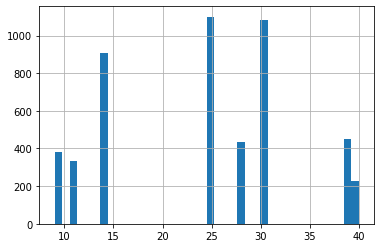

In [9]:
print("Unique problem_description", dataset_df["problem_description"].nunique())
dataset_df["problem_description"].str.split().map(len).hist(bins=40)

Unique question 38


<AxesSubplot:>

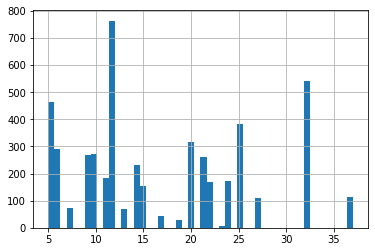

In [10]:
print("Unique question", dataset_df["question"].nunique())
dataset_df["question"].str.split().map(len).hist(bins=50)

Unique answer 872


<AxesSubplot:>

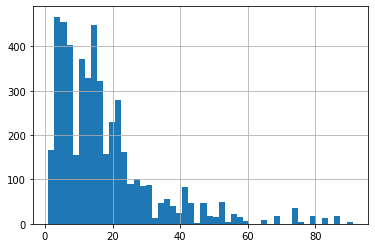

In [11]:
print("Unique answer", dataset_df["answer"].nunique())
dataset_df["answer"].str.split().map(len).hist(bins=50)

Unique reference_answer 181


<AxesSubplot:>

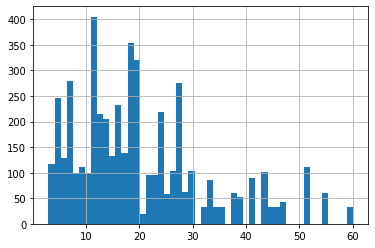

In [12]:
print("Unique reference_answer", dataset_df["reference_answer"].nunique())
dataset_df["reference_answer"].str.split().map(len).hist(bins=50)

In [13]:
# Merge the title with the text body
dataset_df["full_body"] = dataset_df["problem_description"] + " [SEP] " + dataset_df["question"]+ " [SEP] " + dataset_df["reference_answer"]+ " [SEP] " + dataset_df["answer"]
dataset_df.columns

Index(['instance_id', 'task_id', 'student_id', 'problem_description',
       'question', 'answer', 'label', 'context_required',
       'extra_info_in_answer', 'comments', 'reference_answer', 'full_body'],
      dtype='object')

In [14]:
dataset_df.sample(1).to_dict()

{'instance_id': {373: '70'},
 'task_id': {373: 'Demo_LP01_PR01.sh'},
 'student_id': {373: 'DTSU037'},
 'problem_description': {373: 'A mover pushes a box so that it slides across a carpeted floor in a straight line at a constant speed. The push is horizontal.'},
 'question': {373: 'What forces are acting on the box? Which forces balance each other?'},
 'answer': {373: 'The forces that applied to the box is the force from the mover, gravity, the normal, and friction'},
 'label': {373: 1},
 'context_required': {373: '0'},
 'extra_info_in_answer': {373: '0'},
 'comments': {373: ''},
 'reference_answer': {373: 'push, friction, gravity, normal. Friction balances the push.'},
 'full_body': {373: 'A mover pushes a box so that it slides across a carpeted floor in a straight line at a constant speed. The push is horizontal. [SEP] What forces are acting on the box? Which forces balance each other? [SEP] push, friction, gravity, normal. Friction balances the push. [SEP] The forces that applied to

<AxesSubplot:>

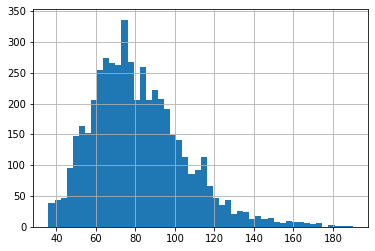

In [15]:
dataset_df["full_body"].str.split().map(len).hist(bins=50)

In [16]:
# Startified split into train:test as 80:20 ratio
qa_eval_train_df, qa_eval_test_df = train_test_split(
    dataset_df[["full_body", "label"]], train_size=0.8, random_state=random_seed, stratify=dataset_df.label
)

In [17]:
# Load pandas dataframes to huggingface datasets
qa_eval_train_dataset = Dataset.from_pandas(qa_eval_train_df)
qa_eval_test_dataset = Dataset.from_pandas(qa_eval_test_df)

### **Define metrics function**

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def compute_auc(pred, run_name):
    import matplotlib.pyplot as plt
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y = label_binarize(labels, classes=list(_LABELS_ID2NAME.keys()))
    p = label_binarize(preds, classes=list(_LABELS_ID2NAME.keys()))
    n_classes = y.shape[1]
    lw = 2

    for i in range(y.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], p[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), p.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "gray"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

    print("\nConfusion Matrix : \n", confusion_matrix(labels, preds.flatten()))
    print("\nClassification Report : \n", classification_report(labels, preds.flatten(), digits=3))

    return {
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
    }

### **Training Setup**

In [19]:
def start_training(model, tokenizer, run_name):

    def tokenize_function(example):
        return tokenizer(example["full_body"], truncation=True)

    qa_eval_train_tokenized_dataset = qa_eval_train_dataset.map(tokenize_function, batched=True)
    qa_eval_test_tokenized_dataset = qa_eval_test_dataset.map(tokenize_function, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        run_name,
        num_train_epochs=4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        learning_rate=5e-5,
        weight_decay=0.01,
        logging_steps=500,
        save_steps=2000,
        seed=random_seed,
        evaluation_strategy='epoch',
        logging_dir=f"./{run_name}/logs",
        report_to=None,
    )

    trainer = Trainer(
        model,
        training_args,
        train_dataset=qa_eval_train_tokenized_dataset,
        eval_dataset=qa_eval_test_tokenized_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval = trainer.evaluate()

    trainer.save_model(f"./{run_name}/model")

    predictions = trainer.predict(qa_eval_test_tokenized_dataset)
    print(predictions.predictions.shape, predictions.label_ids.shape)

    return eval, compute_metrics(predictions), predictions, trainer


In [20]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

In [21]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=len(_LABELS_ID2NAME))

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

In [22]:
roberta_valid_scores, roberta_test_scores, roberta_test_preds, trainer = start_training(
    model, tokenizer, "distil_roberta_base"
)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: full_body, __index_level_0__. If full_body, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/giyaseddin/anaconda3/envs/hf_trfm_gpu/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3936
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, d

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.773334,0.713706,0.711398,0.746059,0.713706
2,1.069200,0.404932,0.885279,0.884592,0.886699,0.885279
3,0.473700,0.247099,0.931980,0.931675,0.933794,0.931980
4,0.228000,0.205577,0.954315,0.954210,0.955258,0.954315


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: full_body, __index_level_0__. If full_body, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 985
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: full_body, __index_level_0__. If full_body, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 985
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: full_body, __index_level_0__. If full_body, __index_level_0__ are not expected by `R

Saving model checkpoint to ./distil_roberta_base/model
Configuration saved in ./distil_roberta_base/model/config.json
Model weights saved in ./distil_roberta_base/model/pytorch_model.bin
tokenizer config file saved in ./distil_roberta_base/model/tokenizer_config.json
Special tokens file saved in ./distil_roberta_base/model/special_tokens_map.json
The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: full_body, __index_level_0__. If full_body, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 985
  Batch size = 16


(985, 4) (985,)


In [23]:
"Validation", roberta_valid_scores, "Test", roberta_test_scores

('Validation',
 {'eval_loss': 0.20557698607444763,
  'eval_accuracy': 0.9543147208121827,
  'eval_f1': 0.9542102983491006,
  'eval_precision': 0.9552580420882951,
  'eval_recall': 0.9543147208121827,
  'eval_runtime': 18.6356,
  'eval_samples_per_second': 52.856,
  'eval_steps_per_second': 3.327,
  'epoch': 4.0},
 'Test',
 {'accuracy': 0.9543147208121827,
  'f1': 0.9542102983491006,
  'precision': 0.9552580420882951,
  'recall': 0.9543147208121827})

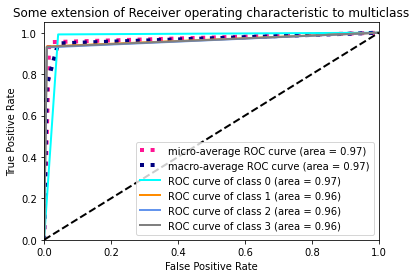


Confusion Matrix : 
 [[363   3   0   0]
 [ 14 240   0   3]
 [  5   0 105   3]
 [  7   3   7 232]]

Classification Report : 
               precision    recall  f1-score   support

           0      0.933     0.992     0.962       366
           1      0.976     0.934     0.954       257
           2      0.938     0.929     0.933       113
           3      0.975     0.932     0.953       249

    accuracy                          0.954       985
   macro avg      0.955     0.947     0.950       985
weighted avg      0.955     0.954     0.954       985



{'roc_auc': {0: 0.974900023835377,
  1: 0.9628051909180314,
  2: 0.9605880084436145,
  3: 0.9617873668587393,
  'micro': 0.9695431472081218,
  'macro': 0.9650201475139405},
 'fpr': {0: array([0.        , 0.04200323, 1.        ]),
  1: array([0.        , 0.00824176, 1.        ]),
  2: array([0.        , 0.00802752, 1.        ]),
  3: array([0.        , 0.00815217, 1.        ]),
  'micro': array([0.        , 0.01522843, 1.        ]),
  'macro': array([0.        , 0.00802752, 0.00815217, 0.00824176, 0.04200323,
         1.        ])},
 'tpr': {0: array([0.        , 0.99180328, 1.        ]),
  1: array([0.        , 0.93385214, 1.        ]),
  2: array([0.        , 0.92920354, 1.        ]),
  3: array([0.        , 0.93172691, 1.        ]),
  'micro': array([0.        , 0.95431472, 1.        ]),
  'macro': array([0.        , 0.73645295, 0.74428363, 0.74735324, 0.94839815,
         1.        ])}}

In [24]:
compute_auc(roberta_test_preds, "distil_roberta_base")

In [25]:
roberta_test_preds

PredictionOutput(predictions=array([[-2.9021199, -2.7254179, -0.3073046,  6.410357 ],
       [ 6.3877916, -2.2365339, -2.6514163, -2.4289572],
       [-2.4216282,  6.724943 , -1.5569476, -2.7848277],
       ...,
       [ 6.555481 , -2.3767498, -2.7411993, -2.374771 ],
       [-2.5698583,  6.887278 , -1.5025316, -2.7175767],
       [ 6.4152703, -2.286636 , -2.1908414, -2.930056 ]], dtype=float32), label_ids=array([3, 0, 1, 2, 0, 0, 3, 0, 0, 0, 0, 3, 2, 3, 0, 0, 3, 0, 0, 0, 3, 1,
       1, 2, 3, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0, 3, 1, 3, 0, 2, 1, 0,
       2, 0, 3, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 2, 0, 3, 3, 0, 1, 1, 3, 1,
       2, 3, 1, 1, 2, 0, 1, 3, 0, 0, 0, 1, 0, 1, 1, 0, 0, 3, 2, 1, 3, 0,
       0, 0, 1, 3, 1, 0, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 1, 3, 0,
       3, 3, 0, 0, 3, 0, 3, 3, 1, 0, 1, 0, 0, 3, 0, 1, 0, 2, 0, 0, 1, 3,
       1, 1, 3, 0, 3, 3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 3, 1, 1, 1, 0,
       3, 0, 1, 0, 0, 3, 0, 1, 3, 1, 0, 1, 2, 2, 0, 1, 3, 0, 3, 3, 0, 0,
      

In [26]:
roberta_test_preds.predictions.shape

(985, 4)

### The following codes are for inspecting the wrongly predicted evaluations

In [ ]:
labels = roberta_test_preds.label_ids
preds = roberta_test_preds.predictions.argmax(-1)
for idx, (actual, pred) in enumerate(zip(labels, preds)):
    if actual != pred:
        print(f"** Actual {actual} and Prediction {pred} **")
        print(qa_eval_test_df.iloc[idx])
        print(qa_eval_test_df.iloc[idx]["full_body"])

        print("-"*30)